# Lab 01 : Vanilla VAE - solution

The goal is to implement a VAE architecture with MLPs to generate new MNIST images.</br>

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture15/lab01_VAE'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

In [3]:
#device= torch.device("cuda")
device= torch.device("cpu")
print(device)

cpu


In [4]:
# Libraries
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

### MNIST dataset 

In [5]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
print(train_data.size())

torch.Size([60000, 28, 28])


### Network architecture

In [6]:
# Global constants
# n : nb of pixels along each spatial dimension
# dz : latent dimension
# d : hidden dimension
# b : batch size
n = train_data.size(1)
dz = 20
d = 400
b = 64


In [7]:
# Define  VAE architecture
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        # COMPLETE HERE
        # Encoder x => z
        self.linear_q        = nn.Linear(n**2, d, bias=True)
        self.linear_q_mu     = nn.Linear(d, dz, bias=True)
        self.linear_q_logvar = nn.Linear(d, dz, bias=True)
        # Decoder z => x
        self.linear1_p = nn.Linear(dz, d, bias=True)
        self.linear2_p = nn.Linear(d, n**2, bias=True)
        
    def forward(self, x, train=True): 
        # COMPLETE HERE
        # Encoder x => z
        if train:
            h = self.linear_q(x) # [b, d]
            h = torch.relu(h) # [b, d]
            q_mu = self.linear_q_mu(h) # [b, dz]
            q_logvar = self.linear_q_logvar(h) # [b, dz]
            q_std = torch.exp(0.5*q_logvar) # [b, dz]
            eps = torch.randn_like(q_std) # [b, dz]
            z = q_mu + eps * q_std # [b, dz]
        else:
            z = torch.Tensor(b, dz).normal_(mean=0.0, std=1.0) # [b, dz]
            q_mu, q_logvar = _, _
        # Decoder z => x
        h = self.linear1_p(z) # [b, d]
        h = torch.relu(h)
        h = self.linear2_p(h) # [b, n**2]
        x_hat = torch.sigmoid(h)
        return x_hat, q_mu, q_logvar
    
# Instantiate the network
net = VAE()
net = net.to(device)
print(net)
utils.display_num_param(net) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
b = 64
idx = torch.LongTensor(b).random_(0,60000)
batch_images = train_data[idx,:,:].view(b,-1) # [b, n**2]
print(batch_images.size())
optimizer.zero_grad()
x_hat, q_mu, q_logvar = net(batch_images) # [b, n**2]
print(x_hat.size())
# loss
p_x = batch_images # we assume that images are Bernoulli distribution
p_xz = x_hat       # we do not perform Bernoulli sampling
loss_data =  nn.BCELoss()(p_xz, p_x)
loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
loss = 10* loss_data + loss_KL
loss.backward()
optimizer.step()


VAE(
  (linear_q): Linear(in_features=784, out_features=400, bias=True)
  (linear_q_mu): Linear(in_features=400, out_features=20, bias=True)
  (linear_q_logvar): Linear(in_features=400, out_features=20, bias=True)
  (linear1_p): Linear(in_features=20, out_features=400, bias=True)
  (linear2_p): Linear(in_features=400, out_features=784, bias=True)
)
There are 652824 (0.65 million) parameters in this neural network
torch.Size([64, 784])
torch.Size([64, 784])


In [8]:
# Training loop
net = VAE()
net = net.to(device)
utils.display_num_param(net) 

# Optimizer
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)

# Number of mini-batches per epoch
nb_batch = 200 # Nb of mini-batches per epoch
b = 64  # Batch size

start=time.time()
for epoch in range(10):

    running_loss = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        idx = torch.LongTensor(b).random_(0,60000)
        batch_images = train_data[idx,:,:].view(b,-1)
        optimizer.zero_grad()
        x_hat, q_mu, q_logvar = net(batch_images) 
        # loss
        p_x = batch_images # we assume that images are Bernoulli distribution
        p_xz = x_hat       # we do not perform Bernoulli sampling
        loss_data =  nn.BCELoss()(p_xz, p_x)
        loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
        loss = 10* loss_data + loss_KL
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )
    

There are 652824 (0.65 million) parameters in this neural network
epoch= 0 	 time= 0.022624568144480387 min 	 lr= 0.001 	 loss= 2.7767587053775786
epoch= 1 	 time= 0.04191916783650716 min 	 lr= 0.001 	 loss= 2.266047875881195
epoch= 2 	 time= 0.06550201574961344 min 	 lr= 0.001 	 loss= 2.1733419352769854
epoch= 3 	 time= 0.08592739899953207 min 	 lr= 0.001 	 loss= 2.1178864854574204
epoch= 4 	 time= 0.10958911577860514 min 	 lr= 0.001 	 loss= 2.08133813560009
epoch= 5 	 time= 0.1340195854504903 min 	 lr= 0.001 	 loss= 2.042409123182297
epoch= 6 	 time= 0.1539832830429077 min 	 lr= 0.001 	 loss= 2.029651733636856
epoch= 7 	 time= 0.17339411576588948 min 	 lr= 0.001 	 loss= 2.012923986315727
epoch= 8 	 time= 0.19458671808242797 min 	 lr= 0.001 	 loss= 2.0058939170837404
epoch= 9 	 time= 0.2169444481531779 min 	 lr= 0.001 	 loss= 1.99196513235569


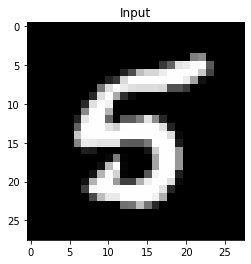

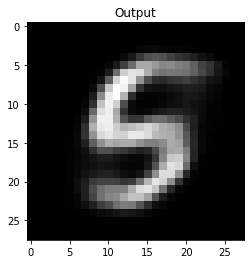

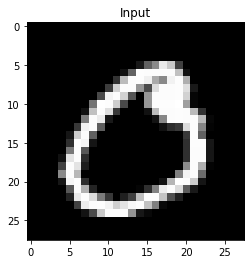

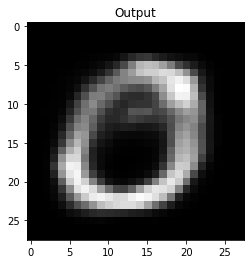

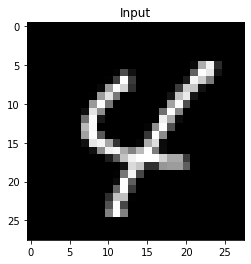

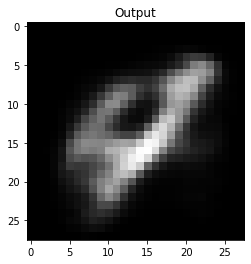

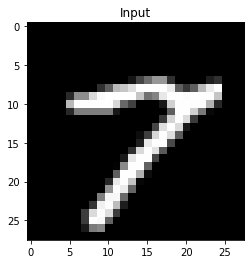

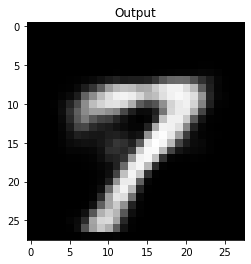

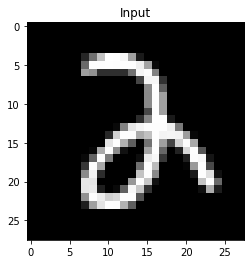

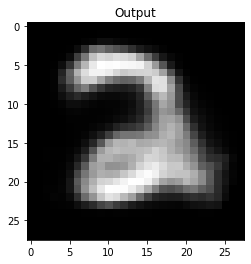

In [9]:
# Test time - auto-encode training data
b = 5
idx = torch.LongTensor(b).random_(0,60000)
batch_images = train_data[idx,:,:].view(b,-1)
x_hat, _, _ = net(batch_images) 

batch_images = batch_images.view(b,n,n)
x_hat = x_hat.view(b,n,n).detach()
        
for b in range(b):
    plt.imshow(batch_images[b,:,:], cmap='gray')
    plt.title('Input')
    #plt.axis('off')
    plt.show() 
    plt.imshow(x_hat[b,:,:], cmap='gray')
    plt.title('Output')
    plt.show() 

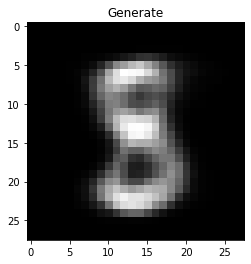

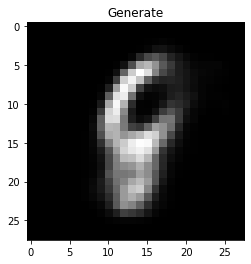

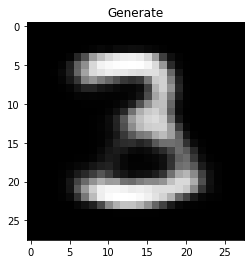

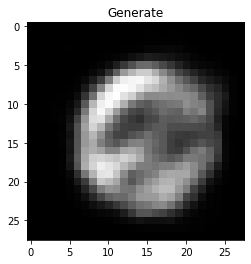

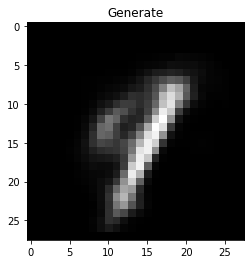

In [11]:
# Test time - generate new data
b = 5
x = torch.zeros(b, n**2)
x_hat, _, _ = net(x, False) 
x_hat = x_hat.view(b,n,n).detach()
        
for b in range(b):
    plt.imshow(x_hat[b,:,:], cmap='gray')
    plt.title('Generate')
    #plt.axis('off')
    plt.show() 